In [ ]:
## First use the notebook DeepLearning-DataPoisoning to generate a poisoned dataset

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

/opt/anaconda3/envs/adobe/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [20]:
class FModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(FModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers

        input_dim_list = [input_dim]+[hidden_dim]*(num_layers-1)
        
        self.hidden_layers = []
        for i in range(num_layers):
            self.hidden_layers.append(nn.Linear(input_dim_list[i], hidden_dim))
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.logit_layer = nn.Linear(hidden_dim, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        out = x
        for i in range(self.num_layers):
            out = self.hidden_layers[i](out).relu()
        out = self.logit_layer(out)
        return out

    def train(self, trainloader, testloader=None, ptestloader=None, stestloader=None, num_epochs=1, rec_freq=100):
        acc, pacc, sacc = [], [], []
        for epoch in range(num_epochs):
            for i, data in enumerate(trainloader):
                input, labels = data
                self.optimizer.zero_grad()
                outputs = self(input.reshape(input.shape[0], -1))
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                if (i+1)%rec_freq == 0:
                    if testloader:
                        acc.append(self.test(testloader))
                    if ptestloader:
                        pacc.append(self.test(ptestloader))
                    if stestloader:
                        sacc.append(self.test(stestloader))
                    print(loss.item())
        return acc, pacc, sacc

    def test(self, testloader):
        acc = 0
        with torch.no_grad():
            for i, data in enumerate(testloader):
                input, labels = data
                outputs = self(input.reshape(input.shape[0], -1))
                pred_labels = torch.argmax(outputs, dim=1)
                acc += torch.sum(labels == pred_labels)
        acc = acc/len(testloader.sampler)
        return acc

In [3]:
class GModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, k, num_layers, num_classes, prev_model=None):
        super(GModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.num_classes = num_classes
        self.num_layers = num_layers

        input_dim_list = [input_dim]+[hidden_dim]*(num_layers-1)
        
        self.fixedw_layers = []
        self.hidden_layers = []
        for i in range(num_layers):
            self.fixedw_layers.append(nn.Linear(input_dim_list[i], k*hidden_dim, bias=False).requires_grad_(False))
            self.hidden_layers.append(nn.Conv1d(in_channels=hidden_dim,
                                      out_channels=hidden_dim,
                                      kernel_size=k,
                                      stride=k,
                                      groups=hidden_dim))
        self.fixedw_layers = nn.ModuleList(self.fixedw_layers)
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.logit_layer = nn.Linear(hidden_dim, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

        def set_weights(prev_fixedw, prev_hiddenw, fixedw, hiddenw, dim):
            for i in range(hidden_dim):
                Y = prev_fixedw[i*k:(i+1)*k, :].T
                x = Y@prev_hiddenw[i:i+1, 0, :].detach().T
                x_norm = torch.norm(x)
                x_unit = x/x_norm
                U = torch.svd(torch.eye(dim)-x_unit@x_unit.T)[0][:, :-1]
                V = torch.svd(torch.randn(dim-1, dim-1))[0][:, :k-1]
                Y[:, :1], Y[:, 1:] = x_unit, U@V
                fixedw[i*k:(i+1)*k, :] = Y.T
                hiddenw[i, 0, 0] = x_norm
            return
        
        with torch.no_grad():
            if prev_model:
                self.logit_layer.weight = prev_model.logit_layer.weight
                self.logit_layer.bias = prev_model.logit_layer.bias
                for i in range(num_layers):
                    self.hidden_layers[i].weight[:] = 0
                    self.hidden_layers[i].bias = prev_model.hidden_layers[i].bias
                    set_weights(prev_model.fixedw_layers[i].weight, prev_model.hidden_layers[i].weight,
                               self.fixedw_layers[i].weight, self.hidden_layers[i].weight, input_dim_list[i])
            else:
                for i in range(num_layers):
                    for j in range(hidden_dim):
                        Y = torch.svd(torch.randn(input_dim_list[i], k))[0][:, :k]
                        self.fixedw_layers[i].weight[j*k:(j+1)*k, :] = Y.T

    def forward(self, x):
        out2 = x
        for i in range(self.num_layers):
            out1 = self.fixedw_layers[i](out2).view(-1, self.hidden_dim, self.k)
            out2 = self.hidden_layers[i](out1).view(-1, self.hidden_dim).relu()
        out = self.logit_layer(out2)
        return out

    def train(self, trainloader, num_epochs=1):
        for epoch in range(num_epochs):
            for i, data in enumerate(trainloader):
                input, labels = data
                self.optimizer.zero_grad()
                outputs = self(input.reshape(input.shape[0], -1))
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                if i%200 == 0: print(loss.item())
        return

    def test(self, testloader):
        acc = 0
        with torch.no_grad():
            for i, data in enumerate(testloader):
                input, labels = data
                outputs = self(input.reshape(input.shape[0], -1))
                pred_labels = torch.argmax(outputs, dim=1)
                acc += torch.sum(labels == pred_labels)
        acc = acc/len(testloader.sampler)
        return acc

In [12]:
import pickle

file = open('poisoned_data_mnist.pickle', 'rb')
poisoned_data = pickle.load(file)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 100

px_train = torch.tensor(poisoned_data['px_train'], dtype=torch.float)
py_train = torch.tensor(np.argmax(poisoned_data['py_train'], axis=1), dtype=torch.long)

x_test = torch.tensor(poisoned_data['x_test'], dtype=torch.float)
y_test = torch.tensor(np.argmax(poisoned_data['y_test'], axis=1), dtype=torch.long)

px_test = torch.tensor(poisoned_data['px_test'], dtype=torch.float)
py_test = torch.tensor(np.argmax(poisoned_data['py_test'], axis=1), dtype=torch.long)

ptraindataset = TensorDataset(px_train, py_train)
ptrainloader = DataLoader(ptraindataset, batch_size=batch_size,
                          shuffle=True, num_workers=2)

testdataset = TensorDataset(x_test, y_test)
testloader = DataLoader(testdataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

ptestdataset = TensorDataset(px_test, py_test)
ptestloader = DataLoader(ptestdataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)

sy_test = torch.zeros(py_test.shape[0])+9
stestdataset = TensorDataset(px_test, sy_test)
stestloader = DataLoader(stestdataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)

In [22]:
input_dim, hidden_dim, num_layers, num_classes = 28*28, 100, 3, 10

num_epochs = 10
num_trials = 10
rec_freq = 100

num_obs = px_train.shape[0]*num_epochs//(rec_freq*batch_size)

acc_full = np.zeros((num_trials, num_obs))
pacc_full = np.zeros((num_trials, num_obs))
sacc_full = np.zeros((num_trials, num_obs))

for nt in range(num_trials):
    print(f"Trial number = {nt}")
    model = FModel(input_dim, hidden_dim, num_layers, num_classes)
    acc_, pacc_, sacc_ = model.train(ptrainloader, testloader=testloader, ptestloader=ptestloader,
                                     stestloader=stestloader, num_epochs=num_epochs, rec_freq=rec_freq)
    acc_full[nt, :] = acc_
    pacc_full[nt, :] = pacc_
    sacc_full[nt, :] = sacc_

Trial number = 0
0.39936983585357666
0.2831173837184906
0.3561977446079254
0.07351426035165787
0.17870403826236725
0.05436277016997337
0.13507722318172455
0.08717933297157288
0.07208697497844696
0.03453288972377777
Trial number = 1
0.42422571778297424
0.46308761835098267
0.19559736549854279
0.08054056018590927
0.15581180155277252
0.21003645658493042
0.08153847604990005
0.1570613980293274
0.04299188777804375
0.10142262279987335
Trial number = 2
0.43121859431266785
0.3553504943847656
0.2778054177761078
0.20113752782344818
0.18427033722400665
0.26656901836395264
0.11218813061714172
0.1244710385799408
0.1111733466386795
0.08005478978157043
Trial number = 3
0.37698763608932495
0.3724793493747711
0.2739003598690033
0.18275463581085205
0.13216890394687653
0.10694930702447891
0.0928700864315033
0.06149490922689438
0.06277170032262802
0.019758669659495354
Trial number = 4
0.4054982662200928
0.36562275886535645
0.17071661353111267
0.18153268098831177
0.08019670844078064
0.21600475907325745
0.091

In [19]:
num_epochs = 5
k_arr = [3, 5, 8, 15, 25]

acc_k = np.zeros((len(k_arr), num_trials, num_obs))
pacc_k = np.zeros((len(k_arr), num_trials, num_obs))
sacc_k = np.zeros((len(k_arr), num_trials, num_obs))

for ik, k in enumerate(k_arr):
    for nt in range(num_trials):
        trained_models = [None]
        acc_, pacc_, sacc_ = [], [], []
        for i in range(num_obs):
            print(f"k = {k}, trial number = {nt}, iteration = {i}")
            model = GModel(input_dim, hidden_dim, k, num_layers, num_classes, prev_model=trained_models[-1])
            model.train(ptrainloader, num_epochs)
            acc_.append(model.test(testloader))
            pacc_.append(model.test(ptestloader))
            sacc_.append(model.test(stestloader))
            trained_models.append(model)
        acc_k[ik, nt, :] = acc_
        pacc_k[ik, nt, :] = pacc_
        sacc_k[ik, nt, :] = sacc_

k = 3, trial number = 0, iteration = 0
2.328232526779175
2.237755537033081
1.9915015697479248
1.533103346824646
1.205456018447876
k = 3, trial number = 0, iteration = 1
0.8470020890235901
0.8034507036209106
0.7720047831535339
0.7633647322654724
0.6862335205078125
k = 3, trial number = 0, iteration = 2
0.6670607924461365
0.758449375629425
0.7307250499725342
0.7044447064399719
0.5338574647903442
k = 3, trial number = 0, iteration = 3
0.624864399433136
0.5792531371116638
0.4992316961288452
0.4391884207725525
0.4587567150592804
k = 3, trial number = 0, iteration = 4
0.6776455640792847
0.5927323698997498
0.5521208047866821
0.6806356906890869
0.5139418840408325
k = 3, trial number = 0, iteration = 5
0.5370176434516907
0.5704376697540283
0.5051755309104919
0.5629263520240784
0.6008620262145996
k = 3, trial number = 0, iteration = 6
0.5401284098625183
0.6557357311248779
0.5282003283500671
0.5160390734672546
0.5970264673233032
k = 3, trial number = 0, iteration = 7
0.5270835161209106
0.59773397

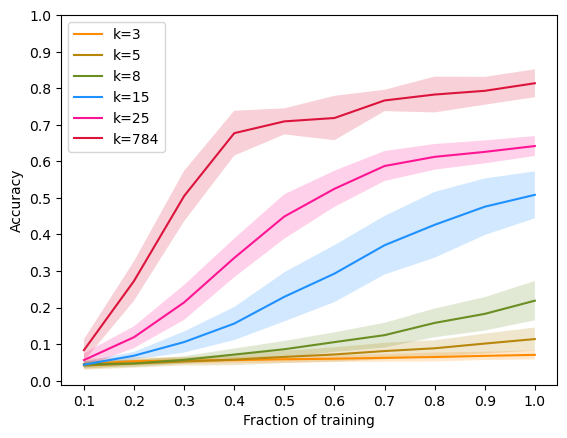

In [8]:
# Plotting code
import matplotlib.lines as mlines

colors = ['darkorange', 'darkgoldenrod', 'olivedrab', 'dodgerblue', 'deeppink', 'crimson']

num_obs = 10

t = np.arange(num_obs)
per_tr = np.round(np.linspace(0.1, 1, num_obs), 2)

fig, ax = plt.subplots(1)
lines = []
for ik, k in enumerate(k_arr):
    mu = np.mean(ascc_k[ik, :, :], axis=0)
    sigma = np.std(ascc_k[ik, :, :], axis=0)
    ax.plot(t, mu, color=colors[ik])
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[ik], alpha=0.2)
    lines.append(mlines.Line2D([], [], color=colors[ik], label=f"k={k}"))
mu = np.mean(sacc_full[:, :], axis=0)
sigma = np.std(sacc_full[:, :], axis=0)
ax.plot(t, mu, label=f"k={k}", color=colors[-1])
ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[-1], alpha=0.2)
lines.append(mlines.Line2D([], [], color=colors[-1], label=f"k=784"))
plt.legend(handles=lines)
ax.set_xticks(ticks=t, labels=per_tr)
ax.set_yticks(ticks=np.round(np.linspace(0, 1, 11), 2))
ax.set_xlabel("Fraction of training")
ax.set_ylabel("Accuracy")
plt.savefig(f'dl_mnist_2.png', bbox_inches='tight')
plt.show()